Tol        | Steps      | Final Error    
----------------------------------------
1e-02      | 13         | 1.3687e-03     
1e-03      | 23         | 6.4039e-05     
1e-04      | 40         | 6.0760e-06     
1e-05      | 72         | 5.0333e-07     
1e-06      | 127        | 4.9790e-08     
1e-07      | 225        | 4.9180e-09     
1e-08      | 401        | 4.7327e-10     


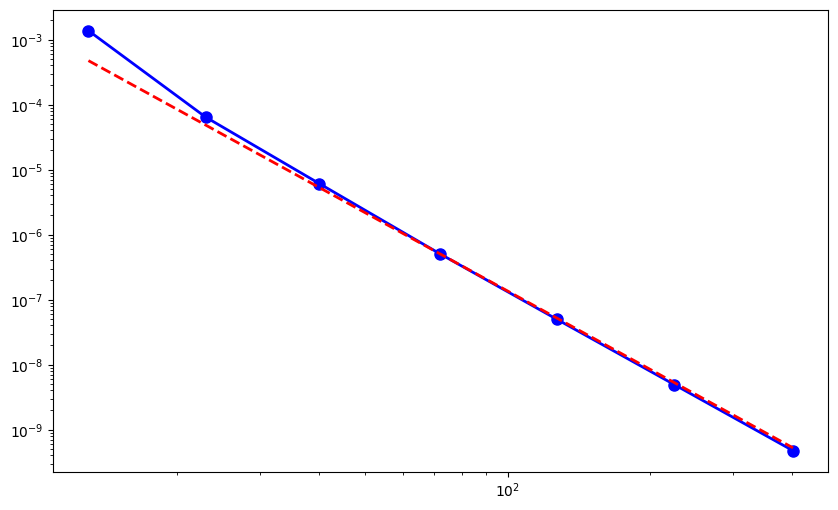

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def rk4(du_dt, tspan, u0, n):
    #引入ab3和ab4都要使用来求前几项的rk4方法
    a, b = tspan
    h = (b - a) / n
    t = np.linspace(a, b, n + 1)

    u = np.zeros((n+1, len(np.atleast_1d(u0))))
    u[0] = u0
    
    for i in range(n):
        k1 = h * du_dt(t[i], u[i])
        k2 = h * du_dt(t[i] + h / 2, u[i] + k1 / 2)
        k3 = h * du_dt(t[i] + h / 2, u[i] + k2 / 2)
        k4 = h * du_dt(t[i] + h, u[i] + k3)
        u[i+1] = u[i] + (k1 + 2 * (k2 + k3) + k4) / 6

    return t, u  

def hermite(x_nodes, y_nodes, yp_nodes, t_target):
    """
    使用牛顿均差法计算 Hermite 插值
    
    参数:
    x_nodes  : 已知点的时间/位置列表 [t0, t1, ...]
    y_nodes  : 已知点的函数值列表   [y0, y1, ...]
    yp_nodes : 已知点的导数值列表   [y'0, y'1, ...]
    t_target : 需要插值的目标时间点
    
    返回:
    插值结果 u(t_target)
    """
    n = len(x_nodes)
    
    # 1. 构造重节点序列 z (每个点重复两次)
    # 例如: x=[0, 1] -> z=[0, 0, 1, 1]
    z = np.zeros(2 * n)
    # Q 是差商表，Q[i, j] 代表 f[z_i, ..., z_{i-j}]
    Q = np.zeros((2 * n, 2 * n)) 
    
    # 2. 初始化前两列 (函数值 和 一阶差商)
    for i in range(n):
        # 填充重节点 z
        z[2*i] = z[2*i+1] = x_nodes[i]
        
        # 第0列: 直接填函数值 y
        Q[2*i, 0] = Q[2*i+1, 0] = y_nodes[i]
        
        # 第1列: y'
        # 如果是重节点 (z[2i+1] == z[2i])，差商就是导数 y'
        Q[2*i+1, 1] = yp_nodes[i]
        
        # 如果是不同节点之间，按普通斜率公式计算
        if i != 0:
            Q[2*i, 1] = (Q[2*i, 0] - Q[2*i-1, 0]) / (z[2*i] - z[2*i-1])
            
    # 3. 计算高阶差商 (从第2列开始，完全套用标准公式)
    for j in range(2, 2 * n):
        for i in range(j, 2 * n):
            # 标准差商递归公式
            Q[i, j] = (Q[i, j-1] - Q[i-1, j-1]) / (z[i] - z[i-j])
            
    result = 0.0
    # 我们遍历每一项，从第 0 项到第 (2n-1) 项
    for i in range(2 * n):
        
        # A. 拿到系数 (对角线元素)
        c = Q[i, i]
        
        # B. 计算后面的连乘积 (t-z0)(t-z1)...(t-zi-1)
        term = 1.0
        for k in range(i):  # 这里的循环就是把括号一个个乘起来
            term = term * (t_target - z[k])
            
        # C. 算出这一整项的值，加到总和里
        current_term_value = c * term
        result += current_term_value
        
    return result
    

def admulti(du_dt, tspan, u0, tol):
    #基于AB4、AB3和Hermite插值法的自适应多步法ODE求解器
    tspan = np.array(tspan)
    u0 = np.array(u0)
    # i 用于记录当前是第几步（成功接受的步数）
    i = 0 
    # 使用列表存储时间点和解，因为我们不知道最终会有多少步（自适应特性）
    t0 = tspan[0]
    tf = tspan[1]
    t = [t0]
    u = [u0]
    # 初始步长猜测：根据容差的4次方根（对应 4 阶方法的误差特性）
    h = 0.5 * tol**(1/4)
    #系数
    k = 4
    sigma3 = np.array([23, -16, 5]) / 12
    sigma4 = np.array([55, -59, 37, -9]) / 24

    #构造初始记录t, u的向量
    ts, us = rk4(du_dt, [t0, t0 + (k - 1) * h], u0, k - 1)
    t = list(ts) 
    u = list(us)
    

    #构造记录f(即u')的向量
    f_hist = []
    for k in range(4):
        # 从列表末尾倒着取: -1, -2, -3, -4
        idx = -1 - k 
        val = du_dt(t[idx], u[idx])
        f_hist.append(val)
    
    f4 = np.array(f_hist)      # 长度 4
    f3 = f4[:3]                # 长度 3 (取前三个即可)

    #主循环
    while t[-1] < tspan[1]:
        #迭代
        unew4 = u[-1] + h * np.dot(sigma4, f4)
        unew3 = u[-1] + h * np.dot(sigma3, f3)
        err = np.max(np.abs(unew4 - unew3))
        
        if err < tol:
            #接受
            t_next = t[-1] + h
            u_next = unew4 # 采纳高阶解
            
            # 存档
            t.append(t_next)
            u.append(u_next)
            
            # 更新历史 f4, f3
            f_new = du_dt(t_next, u_next)
            # 堆栈更新: 新的放头，旧的挤出去 (vstack 逻辑)
            f4 = np.vstack([f_new, f4[:-1]])
            f3 = f4[:3] # f3 始终复用 f4 的前3个最新数据
        else:
            #误差过大，更改步长
            q = (tol / err) ** (1/4)
            h = q * h
            #准备hermite插值数据，使用最后的两个点
            her_t = [t[-2], t[-1]]
            her_u = [u[-2], u[-1]]
            her_yp = [f4[1], f4[0]] #f4[0]为f_n, f4[1]为f_n-1
            #重构f4, (需要 t_now, t_now-h, t_now-2h, t_now-3h)
            new_f_list = []
            # f_n (index 0) 不需要插值，就是当前的导数
            new_f_list.append(f4[0]) 
            # 倒推插值 index 1, 2, 3 (对应 t-h, t-2h, t-3h)
            for k in range(1, 4):
                t_target = t[-1] - k * h
                # 插值求 u
                u_interp = hermite(her_t, her_u, her_yp, t_target)
                # 代入方程求 f (因为 AB 公式用的是 f)
                f_interp = du_dt(t_target, u_interp)
                new_f_list.append(f_interp)
            
            # C. 覆盖旧的 f4 和 f3
            f4 = np.array(new_f_list)
            f3 = f4[:3]
            # 此时循环会回到开头，用更新后的 h 和重构后的 f4 重新尝试这一步

    return np.array(t), np.array(u)

du_dt = lambda t, u: -2 * t * u
u_exact = lambda t: 2 * np.exp(-t**2)
# 选取一组跨度较大的容差，迫使步数发生明显变化
tols = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

steps_list = []  # 记录每次的总步数 (N)
errors_list = [] # 记录每次的最终误差 (E)

print(f"{'Tol':<10} | {'Steps':<10} | {'Final Error':<15}")
print("-" * 40)

for tol in tols:
    # 调用写好的 admulti 求解器
    tt, uu = admulti(du_dt, tspan, u0, tol)
    
    # 获取最后一步的数值解
    u_final_num = uu[-1][0] 
    t_final = tt[-1]
    
    # 计算精确解和误差
    u_final_true = u_exact(t_final)
    global_error = np.abs(u_final_num - u_final_true)
    
    # 记录数据
    steps_list.append(len(tt) - 1) # 步数 = 点数 - 1
    errors_list.append(global_error)
    
    print(f"{tol:<10.0e} | {len(tt)-1:<10} | {global_error:<15.4e}")

#绘图分析
steps = np.array(steps_list)
errors = np.array(errors_list)

plt.figure(figsize=(10, 6))

# A. 绘制实际误差曲线 (圆点实线)
plt.loglog(steps, errors, 'bo-', label='Actual AB4 Adaptive Error', linewidth=2, markersize=8)

# B. 绘制斜率为 -4 的参考直线
# 构造参考线: Error_ref = C * N^(-4)
mid_idx = len(steps) // 2
C = errors[mid_idx] * (steps[mid_idx] ** 4) # 反算常数 C
ref_line = C * (steps.astype(float) ** -4)

plt.loglog(steps, ref_line, 'r--', label='Reference Slope = -4 (O(h^4))', linewidth=2)

# C. 计算实际拟合斜率 (看看是不是接近 -4)
# log(E) = k * log(N) + b
poly = np.polyfit(np.log(steps), np.log(errors), 1)
actual_slope = poly[0]